# USING LAPLACE TRANSFORMS (LTs) TO SOLVE CHEMICAL REACTION NETWORKS

This notebook demonstrates how Laplace transforms and transfer functions can be derived directly from a chemical model.

What we present is *not* a general technique. It only works if the underlying network can be represented by a system of linear differential equations. In practice this means that: (a) all reactions have a single reactant and (b) the kinetics are masss action.

We use the following notation:
* $s$: Laplace transform variable
* $G(s)$: Transfer function
* $S_n$: $n$-th chemical species
* $x_n (t), ~ x_n$: Concentration of $S_n$ at time $t$
* $\dot{x}_n (t), ~ \dot{x}_n$: First derivative of $x(t)$
* $X_n(s)$: Laplace Transform of the concentration of $S_n$

Reactions are described by arrows. The annotation above the arrow is the reaction rate. (Previously, we had assumed mass action kinetics and so just used the kinetic constants.) For example, $S_1$ is converted to $S_2$ at a rate $kx_1$ (where $x_1$ is the concentration of $S_1$ at time $t$) is denoted by $S_1 \xrightarrow{kx_1} S_2$.

# Preliminaries

In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import sympy
import tellurium as te

# Helpers

In [2]:
class PlotResult(object):

    def __init__(self, times=None, yt=None, ax=None):
        self.times = times
        self.yt = yt
        self.ax = ax
        
    def __repr__(self):
        return ""

In [3]:
def plotTF(tf, times=None, is_plot=True, figsize=(5,5)):
    if times is None:
        times = np.linspace(0, 10, 100)
    _, yt = control.forced_response(tf, T=times, U=1)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.plot(times, yt)
        ax.set_xlabel("time")
    else:
        ax = None
    return PlotResult(times=times, yt=yt, ax=ax)

# Tests
tf = control.TransferFunction([1], [1, 0])
plot_result = plotTF(tf, is_plot=False)
assert(isinstance(plot_result, PlotResult))
print("OK!")

OK!


# Model 1: A very simple reaction network

Consider the one step sequential pathway with mass action kinetics
\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & \emptyset \\
\end{eqnarray}

We want to control $s_2$ by manipulating $S_1$.
We will manipulate $s_1$ by controlling its concentration in solution.

We want the transfer function $G(s) = \frac{X_2(s)}{X_1(s)}$.

## 1. System equations

So, the state equations are:
* $\dot{x}_1 = -k_1 x_1$
* $\dot{x}_2 = k_1 x_1 - k_2 x_2$

## 2. LT of system equations

Going from the state equations to Laplace Transforms is very mechanical. Replace $\dot{x}$ with $s X(s)$, and replace $x$ with $X(s)$.

\begin{eqnarray}
s X_1 (s) & = &  -k_1 X_1 (s)\\
s X_2 & = & k_1 X_1 (s) - k_2 X_2 (s)\\
\end{eqnarray}

## 3. Solve for transfer function

$G(s) = \frac{X_2(s)}{X_1(s)}$. This is calculated directly
from the second system equation.

$G(s) = \frac{X_2 (s)}{X_1 (s)} = \frac{k_1}{s + k_2}$

## 4. Predict step response from TF

### 4a. Construct transfer function

The function ``control.TransferFunction`` provides a way to construct transfer functions and calculate with them.

A transfer function represented by a numerator polynomial in $s$ and a denominator polynomial in $s$.
A polynomial in $s$ is a list of floats.
The last element of the list is the coefficient for $s^0$;
element last - 1 is the coefficient for $s^1$; and so on.

For example, [1, 2, 3] represents the polynomial $s^2 + 2 s + 3$.

In [4]:
# Construct the transfer function for G(s) at k1=1
k1 = 1; k2 =2
G_tf = control.TransferFunction([k1], [1, k2])
G_tf

TransferFunction(array([1]), array([1, 2]))

Now try a more complicated transfer function.

$G(s) = \frac{2s +4}{3s^3 + 1}$

In [5]:
tf = control.TransferFunction([2, 4], [3, 0, 0, 1])
tf

TransferFunction(array([2, 4]), array([3, 0, 0, 1]))

In [6]:
# The controls package calculates poles of transfer functions
tf.poles()

array([-0.69336127+0.j        ,  0.34668064+0.60046848j,
        0.34668064-0.60046848j])

In [7]:
# The controls package also calculates DC Gain
tf.dcgain()

4.0

### 4b. Predict step response

Text(0.5, 0, 'time')

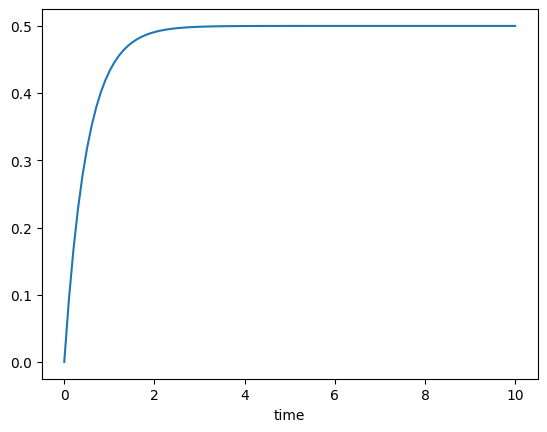

In [8]:
# Use control.forced_response
times = np.linspace(0, 10, 100)
_, yt = control.step_response(G_tf, T=times)
plt.plot(times, yt)
plt.xlabel("time")

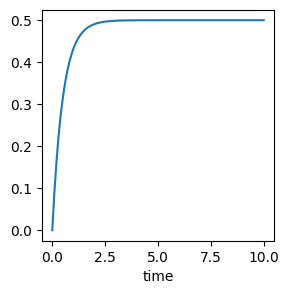

In [9]:
# We can wrap the foregoing into a function
plotTF(G_tf, figsize=(3,3))

## 5. Simulate the Antimony model

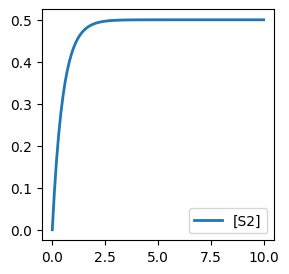

In [10]:
model = """
$S1 -> S2; k1*S1
S2 -> ; k2*S2

S1 = 1
S2 = 0
k1 = 1
k2 = 2
"""
rr = te.loada(model)
rr.simulate(0, 10, 100)
rr.plot(figsize=(3,3))

## 6: Analyze

The results look identical.

# Model 2: A more elaborate network

Consider the following model:
\begin{eqnarray}
S_1 & \xrightarrow{k_1 x_1} & S_2 \\
S_2 & \xrightarrow{k_2 x_2} & S_3 \\
S_3 & \xrightarrow{k_3 x_3} & \emptyset \\
\end{eqnarray}

Find the transfer function $G(s) = \frac{X_3 (s)}{X_1 (s)}$.

## 1. System equations

\begin{eqnarray}
\dot{x}_1 & = &  -k_1 x_1 \\
\dot{x}_2 & = & k_1 x_1 - k_2 x_2\\
\dot{x}_3 & = & k_2 x_2 - k_3 x_3 \\
\end{eqnarray}

## 2. LT of system equations

\begin{eqnarray}
s X_1 (s) & = &  -k_1 X_1 (s) \\
s X_2 (s) & = & k_1 X_1 (s) - k_2 X_2 (s) \\
s X_3 (s) & = & k_2 X_2 (s) - k_3 X_3 (s) \\
\end{eqnarray}

## 3. Solve for the LT

Solve backwards from $X_3 (s)$

\begin{eqnarray}
X_3(s) & = &  \frac{k_2 X_2(s)}{s + k_3} \\
X_2(s) & = &  \frac{k_1 X_1(s)}{s + k_2} \\
\end{eqnarray}

Substituting
\begin{eqnarray}
X_3(s) & = &  \frac{k_2 \frac{k_1 X_1(s)}{s + k_2}}{s + k_3} \\
& = & \frac{k_2 k_1 X_1(s)}{(s + k_3)(s + k_2)} \\
G(s) & = & \frac{X_3(s)}{X_1(s)} \\
& = & \frac{k_2 k_1 }{(s + k_3)(s + k_2)} \\
\end{eqnarray}

## 3a. Interpret $G(s)$

* The poles are $k_2, k_3$. Why?
* The system is always stable. Why?
* The DC Gain is $\frac{k_1}{k_3}$ Why?

## 4. Predict step response from TF

In [11]:
# Construct the transfer function for G(s) at k1=1
k1, k2, k3 = 1, 2, 3
G_tf = control.TransferFunction([k2*k1], [1, k2+k3, k2*k3])
G_tf

TransferFunction(array([2]), array([1, 5, 6]))

In [12]:
G_tf.dcgain(), G_tf.poles()

(0.3333333333333333, array([-3.+0.j, -2.+0.j]))

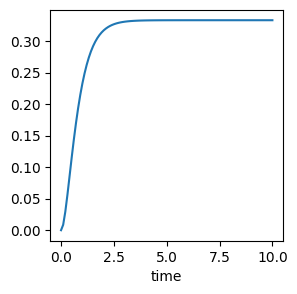

In [13]:
plotTF(G_tf, figsize=(3,3))

## 5. Simulate the Antimony Model

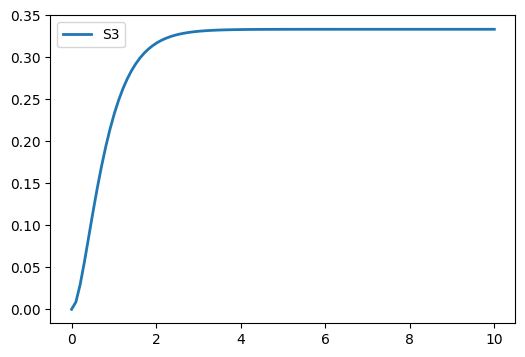

In [14]:
# Model for a unit step response
model = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

$S1 = 1
S2 = 0
S3 = 0
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(model)
rr.simulate(0, 10, 100, selections=['time', 'S3'])
rr.plot()

## 6. Analyze

The actual results match the predicted results, including DC Gain.

# Exercise: Fork-Join

Consider the following network. Find its transfer function and compare with an Antimony simulation.

\begin{eqnarray}
S_1 & \xrightarrow{k_{12} x_1} & S_2 \\
S_1 & \xrightarrow{k_{13} x_1} & S_3 \\
S_2 & \xrightarrow{k_2 x_2} & S_4 \\
S_3 & \xrightarrow{k_3 x_3} & S_4 \\
S_4 & \xrightarrow{k_4 x_4} & \emptyset \\
\end{eqnarray}
Find $G(s) = \frac{X_4(s)}{X_1(s)}$

## System equations

## LT of system equations

## Solve for transfer function & simulate a step response

## Do an Antimony stimulation of a step response

## Evaluate the result